## Experiment 3: INGR Visual Analysis

Analyze the posts photos computing visual characteristics (The categorization of colors is based on the theory of Berlin and Kay (1969) and includes the 11 categories of basic colors, a widely used approach):
- Amazon Rekognition labels of photos
- Dominant color of photos
- Contrast detection of photos

Import modules

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import boto3
from colorthief import ColorThief
import webcolors
import numpy as np
from skimage.exposure import is_low_contrast
from skimage import io

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics

Load and cleanup the data file

In [ ]:
# Load the csv file containing the posts
# Use only "URL" and "Total Interactions" columns
posts_df = pd.read_csv("Datasets/ingr/ingr.csv",
                       usecols=["URL", "Total Interactions"])[
    ["URL", "Total Interactions"]]

# Drop rows with missing values values
posts_df = posts_df.dropna().reset_index(drop=True)

# Filter out rows with "Total Interactions" values below 0.05 quantile and above 0.95 quantile
posts_df = posts_df.loc[(posts_df["Total Interactions"] >= posts_df[
    "Total Interactions"].quantile(.05)) & (posts_df["Total Interactions"] <= posts_df[
    "Total Interactions"].quantile(.95))].reset_index(drop=True)
posts_df

,URL,Total Interactions
0,https://www.facebook.com/293834325961/posts/10...,2
1,https://www.facebook.com/293834325961/posts/10...,2
2,https://www.facebook.com/293834325961/posts/10...,28
3,https://www.facebook.com/293834325961/posts/10...,10
4,https://www.facebook.com/293834325961/posts/10...,7
...,...,...
530,https://www.facebook.com/293834325961/posts/10...,21
531,https://www.facebook.com/293834325961/posts/10...,5
532,https://www.facebook.com/293834325961/posts/10...,4
533,https://www.facebook.com/293834325961/posts/10...,0


Amazon Rekognition labels of photos

In [ ]:
# Path to where your images are
images_dir = "Datasets/ingr/images/"

# Read in your personal keys
personal_access_key = ""
secret_access_key = ""

# Initialize the boto client to access the Rekogniton api
client=boto3.client('rekognition','us-east-1', # or choose the best region for your work,
                                               # e.g. the location of your S3 bucket if using that method to store images
                    aws_access_key_id = personal_access_key,
                    aws_secret_access_key = secret_access_key)

# Fill in this list with a list of labels per post photo
all_labels_list = []

for post in posts_df["URL"].values.tolist():
    filepath = images_dir+post.split("/")[-1].strip()+".jpg"
    with open(filepath, 'rb') as image:
        response = client.detect_labels(Image={'Bytes': image.read()})

    labels_list = []
    for label in response['Labels']:
        if label["Confidence"] > 65.0:
            labels_list.append(label["Name"])
    all_labels_list.append(labels_list)

How many unique labels are there?

In [ ]:
# Adapted from https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
all_labels_flat_list  = [item for sublist in all_labels_list for item in sublist]

unique_labels = list(set(all_labels_flat_list))
print(len(unique_labels))

609


Keep the 300 most common labels

In [ ]:
counter = collections.Counter(all_labels_flat_list)
keep_labels = []
for common in counter.most_common(300):
    keep_labels.append(common[0])

labels_list = []
for labels in all_labels_list:
    labels_dict = {}
    for label in keep_labels:
        labels_dict.update({label: int(label in labels)})
    labels_list.append(labels_dict)

visual_df = pd.DataFrame(labels_list)
# Merge the visual_df with the original posts dataframe
visual_df = posts_df.merge(visual_df, left_index=True, right_index=True, how='inner')
visual_df

,URL,Total Interactions,Person,Human,Clothing,Apparel,Face,Building,Female,Urban,...,Lab,Sand,Coin,Money,Convention Center,Desk,Bridge,Vest,Lifejacket,Bag
0,https://www.facebook.com/293834325961/posts/10...,2,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,https://www.facebook.com/293834325961/posts/10...,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,https://www.facebook.com/293834325961/posts/10...,28,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,https://www.facebook.com/293834325961/posts/10...,10,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,https://www.facebook.com/293834325961/posts/10...,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,https://www.facebook.com/293834325961/posts/10...,21,1,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
531,https://www.facebook.com/293834325961/posts/10...,5,1,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
532,https://www.facebook.com/293834325961/posts/10...,4,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
533,https://www.facebook.com/293834325961/posts/10...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Dominant color of photos

In [ ]:
def is_css3_color(instance):
    if instance.lower() in webcolors.css3_names_to_hex:
        return True
    return is_css_color_code(instance)

def check_color(color_name):
    #Define colors
    PINK = ['pink', 'lightpink', 'hotpink', 'deeppink', 'palevioletred', 'mediumvioletred']
    PURPLE = ['lavender', 'thistle', 'plum', 'orchid', 'violet', 'fuchsia', 'magenta', 'mediumorchid', 'darkorchid', 'darkviolet', 'blueviolet', 'darkmagenta',  'purple',  'mediumpurple',  'mediumslateblue', 'slateblue', 'darkslateblue', 'rebeccapurple',  'indigo']
    RED = ['lightsalmon', 'salmon', 'darksalmon', 'lightcoral', 'indianred', 'crimson', 'red', 'firebrick', 'darkred']
    ORANGE = ['orange', 'darkorange', 'coral', 'tomato', 'orangered']
    YELLOW = ['gold', 'yellow', 'lightyellow', 'lemonchiffon', 'lightgoldenrodyellow', 'papayawhip', 'moccasin', 'peachpuff',  'palegoldenrod', 'khaki', 'darkkhaki']
    GREEN = ['greenyellow', 'chartreuse',  'lawngreen', 'lime',  'limegreen', 'palegreen', 'lightgreen', 'mediumspringgreen', 'springgreen', 'mediumseagreen', 'seagreen', 'forestgreen', 'green', 'darkgreen', 'yellowgreen', 'olivedrab', 'darkolivegreen', 'mediumaquamarine', 'darkseagreen', 'lightseagreen',  'darkcyan',  'teal']
    CYAN= ['aqua', 'cyan', "darkslategray",'lightcyan', 'paleturquoise', 'aquamarine', 'turquoise', 'mediumturquoise', 'darkturquoise']
    BLUE=  ['cadetblue', 'steelblue', 'lightsteelblue', 'lightblue', 'powderblue', 'lightskyblue',  'skyblue', 'cornflowerblue', 'deepskyblue', 'dodgerblue', 'royalblue', 'blue', 'mediumblue',  'darkblue',  'navy',  'MidnightBlue']
    BROWN =  ['cornsilk', 'blanchedalmond', 'bisque', 'navajowhite', 'wheat', 'burlywood', 'tan', 'rosybrown', 'sandybrown', 'goldenrod', 'darkgoldenrod',  'peru', 'chocolate', 'olive', 'saddlebrown',  'sienna',  'brown', 'maroon']
    WHITE = ['white', 'snow', 'honeydew', 'mintcream', 'azure', 'aliceblue',  'ghostwhite', 'whitesmoke', 'seashell',  'beige', 'oldlace',  'floralwhite',  'ivory', 'antiquewhite',  'linen', 'lavenderblush',  'mistyrose']
    GREY = [ 'gainsboro', 'lightgray', 'silver', 'darkgray', 'dimgray',  'gray',  'lightslategray', 'slategray', 'arkslategray', 'black']

    #Check cases
    if color_name in PINK:
        return 'pink'
    elif color_name in PURPLE:
        return 'purple'
    elif color_name in RED:
        return 'red'
    elif color_name in ORANGE:
        return 'orange'
    elif color_name in YELLOW:
        return 'yellow'
    elif color_name in GREEN:
        return 'green'
    elif color_name in CYAN:
        return 'cyan'
    elif color_name in BLUE:
        return 'blue'
    elif color_name in BROWN:
        return 'brown'
    elif color_name in WHITE:
        return 'white'
    elif color_name in GREY:
        return 'grey'
    else:
        return 'No color found'

color_names = []

for post in posts_df["URL"].values.tolist():
    filepath = images_dir+post.split("/")[-1].strip()+".jpg"
    color_thief = ColorThief(filepath)
    dominant_color = color_thief.get_color(quality=1)

    rms_lst = []
    for img_clr, img_hex in webcolors.CSS3_NAMES_TO_HEX.items():
        cur_clr = webcolors.hex_to_rgb(img_hex)
        rmse = np.sqrt(metrics.mean_squared_error(dominant_color, cur_clr))
        rms_lst.append(rmse)
    closest_color = rms_lst.index(min(rms_lst))
    nm = list(webcolors.CSS3_NAMES_TO_HEX.items())[closest_color][0]
    nm = check_color(nm)
    color_names.append(nm)

visual_df['dominantColor'] = color_names
visual_df = pd.get_dummies(visual_df, columns=["dominantColor"])
visual_df

,URL,Total Interactions,Person,Human,Clothing,Apparel,Face,Building,Female,Urban,...,dominantColor_blue,dominantColor_brown,dominantColor_cyan,dominantColor_green,dominantColor_grey,dominantColor_pink,dominantColor_purple,dominantColor_red,dominantColor_white,dominantColor_yellow
0,https://www.facebook.com/293834325961/posts/10...,2,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,https://www.facebook.com/293834325961/posts/10...,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,https://www.facebook.com/293834325961/posts/10...,28,1,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,https://www.facebook.com/293834325961/posts/10...,10,1,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,https://www.facebook.com/293834325961/posts/10...,7,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,https://www.facebook.com/293834325961/posts/10...,21,1,1,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
531,https://www.facebook.com/293834325961/posts/10...,5,1,1,1,1,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
532,https://www.facebook.com/293834325961/posts/10...,4,1,1,1,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
533,https://www.facebook.com/293834325961/posts/10...,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


Contrast detection of photos

In [ ]:
contrast_values = []
for post in posts_df["URL"].values.tolist():
    filepath = images_dir+post.split("/")[-1].strip()+".jpg"
    image = io.imread(filepath)
    image = np.array(image)
    contrast = is_low_contrast(image, fraction_threshold=0.20, lower_percentile=20, upper_percentile=100)
    if contrast: # An einai to contrast true (pou simainei LOW contrast)
        contrast_values.append('LOW')
    else:
        contrast_values.append('HIGH')

visual_df['Contrast'] = contrast_values
visual_df = pd.get_dummies(visual_df, columns=["Contrast"])
visual_df

,URL,Total Interactions,Person,Human,Clothing,Apparel,Face,Building,Female,Urban,...,dominantColor_cyan,dominantColor_green,dominantColor_grey,dominantColor_pink,dominantColor_purple,dominantColor_red,dominantColor_white,dominantColor_yellow,Contrast_HIGH,Contrast_LOW
0,https://www.facebook.com/293834325961/posts/10...,2,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,https://www.facebook.com/293834325961/posts/10...,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,https://www.facebook.com/293834325961/posts/10...,28,1,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,https://www.facebook.com/293834325961/posts/10...,10,1,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,https://www.facebook.com/293834325961/posts/10...,7,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,https://www.facebook.com/293834325961/posts/10...,21,1,1,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0
531,https://www.facebook.com/293834325961/posts/10...,5,1,1,1,1,1,0,1,0,...,1,0,0,0,0,0,0,0,1,0
532,https://www.facebook.com/293834325961/posts/10...,4,1,1,1,1,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
533,https://www.facebook.com/293834325961/posts/10...,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0


Split dataset to train and test subsets

In [ ]:
train_df, test_df = train_test_split(visual_df, test_size=0.25, random_state=42)

Regression problem

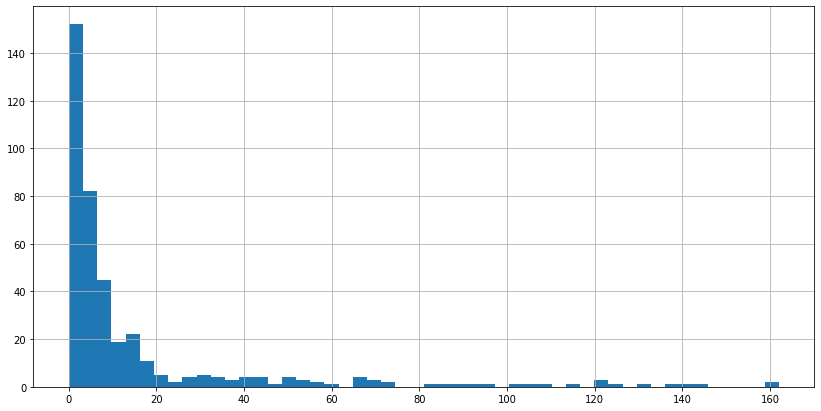

In [ ]:
train_x = train_df.iloc[:, 2:]
train_y = train_df["Total Interactions"]

test_x = test_df.iloc[:, 2:]
test_y = test_df["Total Interactions"]

# Plot how the column we will be predicting looks like
train_df["Total Interactions"].hist(figsize=(14, 7), bins=50)
plt.show()

In [ ]:
# Train and test the LinearRegression model
lin_reg = LinearRegression().fit(train_x, train_y)
pred_y = lin_reg.predict(test_x)

print('r2_score:', metrics.r2_score(test_y, pred_y))
print('MAE:', metrics.mean_absolute_error(test_y, pred_y))
print('MSE:', metrics.mean_squared_error(test_y, pred_y))

r2_score: -1.6984447762458026e+19
MAE: 27845056672.995396
MSE: 1.091684271322554e+22


In [ ]:
# Train and test the KNeighborsRegressor model
kn_reg = KNeighborsRegressor().fit(train_x, train_y)
pred_y = kn_reg.predict(test_x)

print('r2_score:', metrics.r2_score(test_y, pred_y))
print('MAE:', metrics.mean_absolute_error(test_y, pred_y))
print('MSE:', metrics.mean_squared_error(test_y, pred_y))

r2_score: -0.21968668209587539
MAE: 18.402985074626866
MSE: 783.9599999999999


In [ ]:
# Train and test the RandomForestRegressor model
rf_reg = RandomForestRegressor(n_estimators=200).fit(train_x, train_y)
pred_y = rf_reg.predict(test_x)

print('r2_score:', metrics.r2_score(test_y, pred_y))
print('MAE:', metrics.mean_absolute_error(test_y, pred_y))
print('MSE:', metrics.mean_squared_error(test_y, pred_y))

r2_score: -0.5129209468223386
MAE: 20.100703558775383
MSE: 972.4378587398623


In [ ]:
# Show features importances
important_features = pd.Series(data=rf_reg.feature_importances_, index=train_x.columns)
important_features.sort_values(ascending=False, inplace=True)
important_features.astype(float)

dominantColor_grey    3.551478e-02
Clothing              3.522603e-02
Apparel               3.253367e-02
Windshield            3.047847e-02
Vigil                 2.831224e-02
                          ...     
Shrine                3.132489e-06
Bird                  2.808892e-06
Computer Keyboard     2.580014e-06
Computer Hardware     1.613721e-06
Shelter               6.583826e-07
Length: 313, dtype: float64

Classification problem

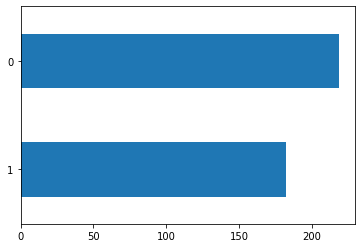

In [ ]:
# For classification, we consider 2 categories:
#   -Class 0: posts with "Total Interactions" below the column's median
#   -Class 1: posts with "Total Interactions" above the column's median

median = train_df["Total Interactions"].median()

train_x = train_df.iloc[:, 2:]
train_y = train_df["Total Interactions"].apply(lambda x: int(x > median))

test_x = test_df.iloc[:, 2:]
test_y = test_df["Total Interactions"].apply(lambda x: int(x > median))

# Plot how the column we will be predicting looks like
train_df["Total Interactions"].apply(
    lambda x: int(x > median)).value_counts().sort_values().plot(kind = 'barh')
plt.show()

In [ ]:
# Train and test the LogisticRegression model
lr_clf = LogisticRegression(solver='lbfgs').fit(train_x, train_y)
pred_y = lr_clf.predict(test_x)

print('accuracy:', metrics.accuracy_score(test_y, pred_y))
print('classification_report:\n', metrics.classification_report(test_y, pred_y))

accuracy: 0.5149253731343284
classification_report:
               precision    recall  f1-score   support

           0       0.58      0.56      0.57        77
           1       0.43      0.46      0.44        57

    accuracy                           0.51       134
   macro avg       0.51      0.51      0.51       134
weighted avg       0.52      0.51      0.52       134



In [ ]:
# Train and test the KNeighborsClassifier model
kn_clf = KNeighborsClassifier().fit(train_x, train_y)
pred_y = kn_clf.predict(test_x)

print('accuracy:', metrics.accuracy_score(test_y, pred_y))
print('classification_report:\n', metrics.classification_report(test_y, pred_y))

accuracy: 0.5522388059701493
classification_report:
               precision    recall  f1-score   support

           0       0.64      0.51      0.57        77
           1       0.48      0.61      0.54        57

    accuracy                           0.55       134
   macro avg       0.56      0.56      0.55       134
weighted avg       0.57      0.55      0.55       134



In [ ]:
# Train and test the RandomForestClassifier model
rf_clf = RandomForestClassifier(n_estimators=200).fit(train_x, train_y)
pred_y = rf_clf.predict(test_x)

print('accuracy:', metrics.accuracy_score(test_y, pred_y))
print('classification_report:\n', metrics.classification_report(test_y, pred_y))

accuracy: 0.5895522388059702
classification_report:
               precision    recall  f1-score   support

           0       0.65      0.62      0.64        77
           1       0.52      0.54      0.53        57

    accuracy                           0.59       134
   macro avg       0.58      0.58      0.58       134
weighted avg       0.59      0.59      0.59       134



In [ ]:
# Show features importances
important_features = pd.Series(data=rf_clf.feature_importances_, index=train_x.columns)
important_features.sort_values(ascending=False, inplace=True)
important_features.astype(float)

dominantColor_brown    0.021143
dominantColor_grey     0.018565
People                 0.018311
dominantColor_cyan     0.016248
Apparel                0.013299
                         ...   
Countryside            0.000301
Sweater                0.000283
Rock                   0.000267
Bridge                 0.000222
Aerial View            0.000166
Length: 313, dtype: float64